In [20]:
    import matplotlib.image as mpimg
    import matplotlib.pyplot as plt
    from PIL import Image
    import cv2
    import os
    import math
    import sys
    import numpy as np
    import pytesseract
    import io 
    import csv
    import pandas as pd
    import shutil, os
    import warnings
    warnings.filterwarnings('ignore')

    file_name = '0896271000.jpeg'
    
    shutil.copytree('/home/vimalkumar.s/Documents/extraction/header/total wages paid/table-ocr_input/sample', 
        os.path.join('/home/vimalkumar.s/Documents/extraction/header/total wages paid/table-ocr_input',
                                 os.path.splitext(file_name)[0]))
    img = mpimg.imread(os.path.join
                       ('/home/vimalkumar.s/Documents/extraction/header/total wages paid/table-ocr_input/input',
                        file_name))
    width = img.shape[1]
    height = img.shape[0]
    wi = width * 0.95
    he = height * 0.3
    w = int(wi)
    h = int(he)
    y = 0
    x1 = w * 0.45
    x = int(x1)
    crop = img[y:y+h, x:x+w]
    #plt.imshow(crop)
    im = Image.fromarray(crop)
    b = os.path.splitext(file_name)[0]+'_crop.jpeg'
    im.save(os.path.join('/home/vimalkumar.s/Documents/extraction/header/total wages paid/table-ocr_input',
                           os.path.splitext(file_name)[0],'crop',b))
    def extract_cell_images_from_table(image):
        BLUR_KERNEL_SIZE = (17, 17)
        STD_DEV_X_DIRECTION = 0
        STD_DEV_Y_DIRECTION = 0
        blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
        MAX_COLOR_VAL = 255
        BLOCK_SIZE = 15
        SUBTRACT_FROM_MEAN = -2

        img_bin = cv2.adaptiveThreshold(
            ~blurred,
            MAX_COLOR_VAL,
            cv2.ADAPTIVE_THRESH_MEAN_C,
            cv2.THRESH_BINARY,
            BLOCK_SIZE,
            SUBTRACT_FROM_MEAN,
        )
        vertical = horizontal = img_bin.copy()
        SCALE = 5
        image_width, image_height = horizontal.shape
        horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
        horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
        vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
        vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)

        horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
        vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))

        mask = horizontally_dilated + vertically_dilated
        contours, heirarchy = cv2.findContours(
            mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE,
        )

        perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
        epsilons = [0.05 * p for p in perimeter_lengths]
        approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]

        # Filter out contours that aren't rectangular. Those that aren't rectangular
        # are probably noise.
        approx_rects = [p for p in approx_polys if len(p) == 4]
        bounding_rects = [cv2.boundingRect(a) for a in approx_polys]

        # Filter out rectangles that are too narrow or too short.
        MIN_RECT_WIDTH = 40
        MIN_RECT_HEIGHT = 10
        bounding_rects = [
            r for r in bounding_rects if MIN_RECT_WIDTH < r[2] and MIN_RECT_HEIGHT < r[3]
        ]

        # The largest bounding rectangle is assumed to be the entire table.
        # Remove it from the list. We don't want to accidentally try to OCR
        # the entire table.
        largest_rect = max(bounding_rects, key=lambda r: r[2] * r[3])
        bounding_rects = [b for b in bounding_rects if b is not largest_rect]

        cells = [c for c in bounding_rects]
        def cell_in_same_row(c1, c2):
            c1_center = c1[1] + c1[3] - c1[3] / 2
            c2_bottom = c2[1] + c2[3]
            c2_top = c2[1]
            return c2_top < c1_center < c2_bottom

        orig_cells = [c for c in cells]
        rows = []
        while cells:
            first = cells[0]
            rest = cells[1:]
            cells_in_same_row = sorted(
                [
                    c for c in rest
                    if cell_in_same_row(c, first)
                ],
                key=lambda c: c[0]
            )

            row_cells = sorted([first] + cells_in_same_row, key=lambda c: c[0])
            rows.append(row_cells)
            cells = [
                c for c in rest
                if not cell_in_same_row(c, first)
            ]

        # Sort rows by average height of their center.
        def avg_height_of_center(row):
            centers = [y + h - h / 2 for x, y, w, h in row]
            return sum(centers) / len(centers)

        rows.sort(key=avg_height_of_center)
        cell_images_rows = []
        for row in rows:
            cell_images_row = []
            for x, y, w, h in row:
                cell_images_row.append(image[y:y+h, x:x+w])
            cell_images_rows.append(cell_images_row)
        return cell_images_rows

    def main(f):
        results = []
        directory, filename = os.path.split(f)
        table = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        rows = extract_cell_images_from_table(table)
        #cell_img_dir = os.path.join(directory, "cells")
        #os.makedirs(cell_img_dir, exist_ok=True)
        out_path = os.path.join('/home/vimalkumar.s/Documents/extraction/header/total wages paid/table-ocr_input',
                                os.path.splitext(file_name)[0],'cells')
        paths = []
        for i, row in enumerate(rows):
            for j, cell in enumerate(row):
                cell_filename = "{:03d}-{:03d}.png".format(i, j)
                path = os.path.join(out_path, cell_filename)
                cv2.imwrite(path, cell)
                paths.append(path)
        return paths

    f = os.path.join('/home/vimalkumar.s/Documents/extraction/header/total wages paid/table-ocr_input',
                           os.path.splitext(file_name)[0],'crop',b)
    main(f)
    
    def main(image_file, tess_args):
        """
        OCR the image and output the text to a file with an extension that is ready
        to be used in Tesseract training (.gt.txt).
        Tries to crop the image so that only the relevant text gets passed to Tesseract.
        Returns the name of the text file that contains the text.
        """
        #file_path = '/home/vimal/Documents/table_detect_samples/structured images/input/011364700/cells'
        #image_file = os.listdir(file_path)

        for f in image_file:
            #print(f)
            directory, filename = os.path.split(f)
            filename_sans_ext, ext = os.path.splitext(filename)
            image = cv2.imread(os.path.join(file_path,f), cv2.IMREAD_GRAYSCALE)
            cropped = crop_to_text(image)
            #ocr_data_dir = os.path.join(directory, "ocr_data")
            #os.makedirs(ocr_data_dir, exist_ok=True)
            #out_imagepath = os.path.join(ocr_data_dir, filename)
            out_path = os.path.join('/home/vimalkumar.s/Documents/extraction/header/total wages paid/table-ocr_input',
                                os.path.splitext(file_name)[0],'text')
            out_txtpath = os.path.join(out_path, "{}.txt".format(filename_sans_ext))
            #cv2.imwrite(out_imagepath, cropped)
            if not tess_args:
                d = os.path.dirname(sys.modules["table_ocr"].__file__)
                tessdata_dir = os.path.join(d, "tessdata")
                tess_args = ["--psm", "7", "-l", "table-ocr", "--tessdata-dir", tessdata_dir]
            txt = ocr_image(cropped, " ".join(tess_args))
            with open(out_txtpath, "w") as txt_file:
                txt_file.write(txt)
            #return out_txtpath
    def crop_to_text(image):
        MAX_COLOR_VAL = 255
        BLOCK_SIZE = 15
        SUBTRACT_FROM_MEAN = -2

        img_bin = cv2.adaptiveThreshold(
            ~image,
            MAX_COLOR_VAL,
            cv2.ADAPTIVE_THRESH_MEAN_C,
            cv2.THRESH_BINARY,
            BLOCK_SIZE,
            SUBTRACT_FROM_MEAN,
        )

        img_h, img_w = image.shape
        horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(img_w * 0.5), 1))
        vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(img_h * 0.7)))
        horizontal_lines = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
        vertical_lines = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
        both = horizontal_lines + vertical_lines
        cleaned = img_bin - both

        # Get rid of little noise.
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        opened = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel)
        opened = cv2.dilate(opened, kernel)

        contours, hierarchy = cv2.findContours(opened, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        bounding_rects = [cv2.boundingRect(c) for c in contours]
        NUM_PX_COMMA = 6
        MIN_CHAR_AREA = 5 * 9
        char_sized_bounding_rects = [(x, y, w, h) for x, y, w, h in bounding_rects if w * h > MIN_CHAR_AREA]
        if char_sized_bounding_rects:
            minx, miny, maxx, maxy = math.inf, math.inf, 0, 0
            for x, y, w, h in char_sized_bounding_rects:
                minx = min(minx, x)
                miny = min(miny, y)
                maxx = max(maxx, x + w)
                maxy = max(maxy, y + h)
            x, y, w, h = minx, miny, maxx - minx, maxy - miny
            cropped = image[y:min(img_h, y+h+NUM_PX_COMMA), x:min(img_w, x+w)]
        else:
            # If we morphed out all of the text, assume an empty image.
            cropped = MAX_COLOR_VAL * np.ones(shape=(20, 100), dtype=np.uint8)
        bordered = cv2.copyMakeBorder(cropped, 5, 5, 5, 5, cv2.BORDER_CONSTANT, None, 255)
        return bordered
    def ocr_image(image, config):
        return pytesseract.image_to_string(
            image,
            lang='eng', config='--psm 6'
        )

    file_path = os.path.join('/home/vimalkumar.s/Documents/extraction/header/total wages paid/table-ocr_input',
                                os.path.splitext(file_name)[0],'cells')
    image_file = os.listdir(file_path)
    tess_args = os.listdir(file_path)

    main(image_file, tess_args)
    
    def text_files_to_csv(files):
        """Files must be sorted lexicographically
        Filenames must be <row>-<colum>.txt.
        000-000.txt
        000-001.txt
        001-000.txt
        etc...
        """
        rows = []
        for f in files:
            directory, filename = os.path.split(f)
            with open(os.path.join(file_path,f)) as of:
                txt = of.read().strip()
            row, column = map(int, filename.split(".")[0].split("-"))
            if row == len(rows):
                rows.append([])
            rows[row].append(txt)

        csv_file = io.StringIO()
        writer = csv.writer(csv_file)
        writer.writerows(rows)
        return csv_file.getvalue()

    def main(files):
        return text_files_to_csv(files)


    file_path = os.path.join('/home/vimalkumar.s/Documents/extraction/header/total wages paid/table-ocr_input',
                                os.path.splitext(file_name)[0],'text')
    file = os.listdir(file_path)
    files = sorted(file)

    a = main(files)
    #print(a)

    c = os.path.splitext(file_name)[0]+'_text.txt'
    t = os.path.splitext(file_name)[0]+'_f-text.txt'

    #cs = os.path.splitext(file_name)[0]+'_xl.csv'

    text_file = open(os.path.join('/home/vimalkumar.s/Documents/extraction/header/total wages paid/table-ocr_input',
                                os.path.splitext(file_name)[0],'txt',c), "wt")
    n = text_file.write(a)
    text_file.close()

    df = pd.read_csv(os.path.join('/home/vimalkumar.s/Documents/extraction/header/total wages paid/table-ocr_input',
                                os.path.splitext(file_name)[0],'txt',c),
        header=None,delimiter=',',names=list(range(4)))
    df_str = df.astype(str)
    df1 = df_str[df_str[0].str.contains('TOTAL WAGES PAID') | df_str[0].str.contains('total wages paid')
                                 | df_str[0].str.contains('Total wages paid')]
    
    final = df1.dropna(axis=1)
    final = final.astype(str)
    #print(final)
    final[0] = final[0].str.replace('\d+','') 
    final[0] = final[0].str.replace(r'[^\w\s]+', '')
    final[0] = final[0].str.replace('\d+', '')
    final[0] = final[0].str.strip()
    
    if final.shape[1]>1:
        final[1] = final[1].str.replace(r'[^\w\s]+', '')
        final[1] = final[1].str.replace(" ","")

    #print(final)
    if len(final) == 0:
        print(os.path.splitext(file_name)[0]+'.tif','TOTAL WAGES PAID',0)
    else:       
        with open(os.path.join('/home/vimalkumar.s/Documents/extraction/header/total wages paid/table-ocr_input',
                                os.path.splitext(file_name)[0],'final_text',t), 'a') as f:
            f.write(final.to_string(header = False, index = False))
        text_file = open(os.path.join('/home/vimalkumar.s/Documents/extraction/header/total wages paid/table-ocr_input',
                                os.path.splitext(file_name)[0],'final_text',t), 'r+')
        print(os.path.splitext(file_name)[0]+'.tif',text_file.read())

0896271000.tif TOTAL WAGES PAID 0


In [21]:
df

,,,,,,,,,,,,,,,,,0,1,2,3
on\n08-96271-0-00 (powor ven)\n=\n1_20 03/31/20 dae\npee a\nPCR WORALA PLA TELA\n(fee racic seat)\n0 Contemut mes Cue\nsre | oe\nO00 Fee\n0 ITERL AT A! Bai an\nae [oe Te\narte OP et & ait tab nave,Tuomunounieoenyo\n08-96771-0-00,A\n3S CALENDAR OUSRTER .\n1 20 07/31/20 i,"""a TOTAL WAGES PAID",“ wucearapyy gees\nfe Contes ern An,“@ tanaQif WADED\ntem 6 Mitwa Som &,UNTER ST ADSEDSMENT DU\nTOFEDENAL ADVANCOS,T Content eis GUE\nWace fem bey Tow\nante 0.000,2100.0,0.0,6100.0,0.0,0.0,aGRT BLOCR\nrower uty\none\nBe,NaN,NaN,NaN,NaN,ow\ntes,NaN,Ca


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1 entries, ('on\n08-96271-0-00 (powor ven)\n=\n1_20 03/31/20 dae\npee a\nPCR WORALA PLA TELA\n(fee racic seat)\n0 Contemut mes Cue\nsre | oe\nO00 Fee\n0 ITERL AT A! Bai an\nae [oe Te\narte OP et & ait tab nave', 'Tuomunounieoenyo\n08-96771-0-00', 'A\n3S CALENDAR OUSRTER .\n1 20 07/31/20 i', '"a TOTAL WAGES PAID', '“ wucearapyy gees\nfe Contes ern An', '“@ tanaQif WADED\ntem 6 Mitwa Som &', 'UNTER ST ADSEDSMENT DU\nTOFEDENAL ADVANCOS', 'T Content eis GUE\nWace fem bey Tow\nante 0.000', 2100.0, 0.0, 6100.0, 0.0, 0.0, 'aGRT BLOCR\nrower uty\none\nBe', nan, nan, nan) to ('on\n08-96271-0-00 (powor ven)\n=\n1_20 03/31/20 dae\npee a\nPCR WORALA PLA TELA\n(fee racic seat)\n0 Contemut mes Cue\nsre | oe\nO00 Fee\n0 ITERL AT A! Bai an\nae [oe Te\narte OP et & ait tab nave', 'Tuomunounieoenyo\n08-96771-0-00', 'A\n3S CALENDAR OUSRTER .\n1 20 07/31/20 i', '"a TOTAL WAGES PAID', '“ wucearapyy gees\nfe Contes ern An', '“@ tanaQif WADED\ntem 6 Mitwa Som

In [23]:
df.dtypes

0    float64
1     object
2    float64
3     object
dtype: object

In [25]:
print(df[0].dtypes)

float64


In [9]:
f[0,1]  = f[0].str.split('',expand=True)

ValueError: Wrong number of items passed 33, placement implies 1

In [26]:
from PIL import Image
import os
path = '/home/vimalkumar.s/Documents/file samples/500 Samples/Good'
for i in os.listdir(path):
    #print(i)
    #c = os.path.splitext(i)[0]
    #print(c)
    img = Image.open(os.path.join(path,i))
    img.seek(0)
    img.save(os.path.join('/home/vimalkumar.s/Documents/extraction/header/total wages paid/table-ocr_input/input',os.path.splitext(i)[0]+'.jpeg'))

Using CPU. Note: This module is much faster with a GPU.


FileNotFoundError: No such file: '/home/vimalkumar.s/Documents/python_new/header extraction/Total Wages Paid/[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]'

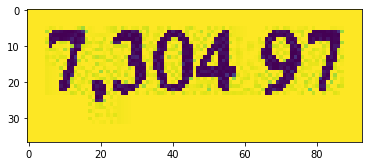

In [11]:
    import matplotlib.image as mpimg
    import matplotlib.pyplot as plt
    from PIL import Image
    import cv2
    import os
    import math
    import sys
    import numpy as np
    import pytesseract
    import io 
    import csv
    import pandas as pd
    import shutil, os
    import easyocr
    import warnings
    warnings.filterwarnings('ignore')
    reader = easyocr.Reader(['en'],gpu = False)
    file_name = '0100477000.jpeg'
    
    shutil.copytree('/home/vimalkumar.s/Documents/extraction/header/total wages paid/table-ocr_input/sample', 
        os.path.join('/home/vimalkumar.s/Documents/extraction/header/total wages paid/table-ocr_input',
                                 os.path.splitext(file_name)[0]))
    img = mpimg.imread(os.path.join
                       ('/home/vimalkumar.s/Documents/extraction/header/total wages paid/table-ocr_input/input',
                        file_name))
    width = img.shape[1]
    height = img.shape[0]
    wi = width * 0.95
    he = height * 0.3
    w = int(wi)
    h = int(he)
    y = 0
    x1 = w * 0.45
    x = int(x1)
    crop = img[y:y+h, x:x+w]
    #plt.imshow(crop)
    im = Image.fromarray(crop)
    b = os.path.splitext(file_name)[0]+'_crop.jpeg'
    im.save(os.path.join('/home/vimalkumar.s/Documents/extraction/header/total wages paid/table-ocr_input',
                           os.path.splitext(file_name)[0],'crop',b))
    def extract_cell_images_from_table(image):
        BLUR_KERNEL_SIZE = (17, 17)
        STD_DEV_X_DIRECTION = 0
        STD_DEV_Y_DIRECTION = 0
        blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
        MAX_COLOR_VAL = 255
        BLOCK_SIZE = 15
        SUBTRACT_FROM_MEAN = -2

        img_bin = cv2.adaptiveThreshold(
            ~blurred,
            MAX_COLOR_VAL,
            cv2.ADAPTIVE_THRESH_MEAN_C,
            cv2.THRESH_BINARY,
            BLOCK_SIZE,
            SUBTRACT_FROM_MEAN,
        )
        vertical = horizontal = img_bin.copy()
        SCALE = 5
        image_width, image_height = horizontal.shape
        horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
        horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
        vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
        vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)

        horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
        vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))

        mask = horizontally_dilated + vertically_dilated
        contours, heirarchy = cv2.findContours(
            mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE,
        )

        perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
        epsilons = [0.05 * p for p in perimeter_lengths]
        approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]

        # Filter out contours that aren't rectangular. Those that aren't rectangular
        # are probably noise.
        approx_rects = [p for p in approx_polys if len(p) == 4]
        bounding_rects = [cv2.boundingRect(a) for a in approx_polys]

        # Filter out rectangles that are too narrow or too short.
        MIN_RECT_WIDTH = 40
        MIN_RECT_HEIGHT = 10
        bounding_rects = [
            r for r in bounding_rects if MIN_RECT_WIDTH < r[2] and MIN_RECT_HEIGHT < r[3]
        ]

        # The largest bounding rectangle is assumed to be the entire table.
        # Remove it from the list. We don't want to accidentally try to OCR
        # the entire table.
        largest_rect = max(bounding_rects, key=lambda r: r[2] * r[3])
        bounding_rects = [b for b in bounding_rects if b is not largest_rect]

        cells = [c for c in bounding_rects]
        def cell_in_same_row(c1, c2):
            c1_center = c1[1] + c1[3] - c1[3] / 2
            c2_bottom = c2[1] + c2[3]
            c2_top = c2[1]
            return c2_top < c1_center < c2_bottom

        orig_cells = [c for c in cells]
        rows = []
        while cells:
            first = cells[0]
            rest = cells[1:]
            cells_in_same_row = sorted(
                [
                    c for c in rest
                    if cell_in_same_row(c, first)
                ],
                key=lambda c: c[0]
            )

            row_cells = sorted([first] + cells_in_same_row, key=lambda c: c[0])
            rows.append(row_cells)
            cells = [
                c for c in rest
                if not cell_in_same_row(c, first)
            ]

        # Sort rows by average height of their center.
        def avg_height_of_center(row):
            centers = [y + h - h / 2 for x, y, w, h in row]
            return sum(centers) / len(centers)

        rows.sort(key=avg_height_of_center)
        cell_images_rows = []
        for row in rows:
            cell_images_row = []
            for x, y, w, h in row:
                cell_images_row.append(image[y:y+h, x:x+w])
            cell_images_rows.append(cell_images_row)
        return cell_images_rows

    def main(f):
        results = []
        directory, filename = os.path.split(f)
        table = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        rows = extract_cell_images_from_table(table)
        #cell_img_dir = os.path.join(directory, "cells")
        #os.makedirs(cell_img_dir, exist_ok=True)
        out_path = os.path.join('/home/vimalkumar.s/Documents/extraction/header/total wages paid/table-ocr_input',
                                os.path.splitext(file_name)[0],'cells')
        paths = []
        for i, row in enumerate(rows):
            for j, cell in enumerate(row):
                cell_filename = "{:03d}-{:03d}.png".format(i, j)
                path = os.path.join(out_path, cell_filename)
                cv2.imwrite(path, cell)
                paths.append(path)
        return paths

    f = os.path.join('/home/vimalkumar.s/Documents/extraction/header/total wages paid/table-ocr_input',
                           os.path.splitext(file_name)[0],'crop',b)
    main(f)
    
    def main(image_file):
        """
        OCR the image and output the text to a file with an extension that is ready
        to be used in Tesseract training (.gt.txt).
        Tries to crop the image so that only the relevant text gets passed to Tesseract.
        Returns the name of the text file that contains the text.
        """
        #file_path = '/home/vimal/Documents/table_detect_samples/structured images/input/011364700/cells'
        #image_file = os.listdir(file_path)

        for f in image_file:
            #print(f)
            directory, filename = os.path.split(f)
            filename_sans_ext, ext = os.path.splitext(filename)
            image = cv2.imread(os.path.join(file_path,f), cv2.IMREAD_GRAYSCALE)
            cropped = crop_to_text(image)
            plt.imshow(cropped)
            #ocr_data_dir = os.path.join(directory, "ocr_data")
            #os.makedirs(ocr_data_dir, exist_ok=True)
            #out_imagepath = os.path.join(ocr_data_dir, filename)
            out_path = os.path.join('/home/vimalkumar.s/Documents/extraction/header/total wages paid/table-ocr_input',
                                os.path.splitext(file_name)[0],'text')
            out_txtpath = os.path.join(out_path, "{}.txt".format(filename_sans_ext))
            #cv2.imwrite(out_imagepath, cropped)
            #if not tess_args:
                #d = os.path.dirname(sys.modules["table_ocr"].__file__)
                #tessdata_dir = os.path.join(d, "tessdata")
                #tess_args = ["--psm", "7", "-l", "table-ocr", "--tessdata-dir", tessdata_dir]
            #txt = easyocr(cropped, " ".join(tess_args))
            txt = easyocr(cropped)
            print(txt)
            with open(out_txtpath, "w") as txt_file:
                txt_file.write(txt)
            #return out_txtpath
    def crop_to_text(image):
        MAX_COLOR_VAL = 255
        BLOCK_SIZE = 15
        SUBTRACT_FROM_MEAN = -2

        img_bin = cv2.adaptiveThreshold(
            ~image,
            MAX_COLOR_VAL,
            cv2.ADAPTIVE_THRESH_MEAN_C,
            cv2.THRESH_BINARY,
            BLOCK_SIZE,
            SUBTRACT_FROM_MEAN,
        )

        img_h, img_w = image.shape
        horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(img_w * 0.5), 1))
        vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(img_h * 0.7)))
        horizontal_lines = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
        vertical_lines = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
        both = horizontal_lines + vertical_lines
        cleaned = img_bin - both

        # Get rid of little noise.
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        opened = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel)
        opened = cv2.dilate(opened, kernel)

        contours, hierarchy = cv2.findContours(opened, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        bounding_rects = [cv2.boundingRect(c) for c in contours]
        NUM_PX_COMMA = 6
        MIN_CHAR_AREA = 5 * 9
        char_sized_bounding_rects = [(x, y, w, h) for x, y, w, h in bounding_rects if w * h > MIN_CHAR_AREA]
        if char_sized_bounding_rects:
            minx, miny, maxx, maxy = math.inf, math.inf, 0, 0
            for x, y, w, h in char_sized_bounding_rects:
                minx = min(minx, x)
                miny = min(miny, y)
                maxx = max(maxx, x + w)
                maxy = max(maxy, y + h)
            x, y, w, h = minx, miny, maxx - minx, maxy - miny
            cropped = image[y:min(img_h, y+h+NUM_PX_COMMA), x:min(img_w, x+w)]
        else:
            # If we morphed out all of the text, assume an empty image.
            cropped = MAX_COLOR_VAL * np.ones(shape=(20, 100), dtype=np.uint8)
        bordered = cv2.copyMakeBorder(cropped, 5, 5, 5, 5, cv2.BORDER_CONSTANT, None, 255)
        return bordered
    #def ocr_image(image, config):
        #return pytesseract.image_to_string(
            #image,
            #lang='eng', config='--psm 6'
        #)
    def easyocr(image):
        #reader = easyocr.Reader(['en'],gpu = False)
        #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        #sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        #sharpen = cv2.filter2D(gray, -1, sharpen_kernel)
        #thresh = cv2.threshold(sharpen, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        r_easy_ocr=reader.readtext(image)
        return

    file_path = os.path.join('/home/vimalkumar.s/Documents/extraction/header/total wages paid/table-ocr_input',
                                os.path.splitext(file_name)[0],'cells')
    image_file = os.listdir(file_path)
    #tess_args = os.listdir(file_path)

    main(image_file)
    
    def text_files_to_csv(files):
        """Files must be sorted lexicographically
        Filenames must be <row>-<colum>.txt.
        000-000.txt
        000-001.txt
        001-000.txt
        etc...
        """
        rows = []
        for f in files:
            directory, filename = os.path.split(f)
            with open(os.path.join(file_path,f)) as of:
                txt = of.read().strip()
            row, column = map(int, filename.split(".")[0].split("-"))
            if row == len(rows):
                rows.append([])
            rows[row].append(txt)

        csv_file = io.StringIO()
        writer = csv.writer(csv_file)
        writer.writerows(rows)
        return csv_file.getvalue()

    def main(files):
        return text_files_to_csv(files)


    file_path = os.path.join('/home/vimalkumar.s/Documents/extraction/header/total wages paid/table-ocr_input',
                                os.path.splitext(file_name)[0],'text')
    file = os.listdir(file_path)
    files = sorted(file)

    a = main(files)
    #print(a)

    c = os.path.splitext(file_name)[0]+'_text.txt'
    t = os.path.splitext(file_name)[0]+'_f-text.txt'

    #cs = os.path.splitext(file_name)[0]+'_xl.csv'

    text_file = open(os.path.join('/home/vimalkumar.s/Documents/extraction/header/total wages paid/table-ocr_input',
                                os.path.splitext(file_name)[0],'txt',c), "wt")
    n = text_file.write(a)
    text_file.close()

    df = pd.read_csv(os.path.join('/home/vimalkumar.s/Documents/extraction/header/total wages paid/table-ocr_input',
                                os.path.splitext(file_name)[0],'txt',c),
        header=None,delimiter=',',names=list(range(4)))
    df_str = df.astype(str)
    df1 = df_str[df_str[0].str.contains('TOTAL WAGES PAID') | df_str[0].str.contains('total wages paid')
                                 | df_str[0].str.contains('Total wages paid')]
    
    final = df1.dropna(axis=1)
    final = final.astype(str)
    #print(final)
    final[0] = final[0].str.replace('\d+','') 
    final[0] = final[0].str.replace(r'[^\w\s]+', '')
    final[0] = final[0].str.replace('\d+', '')
    final[0] = final[0].str.strip()
    
    if final.shape[1]>1:
        final[1] = final[1].str.replace(r'[^\w\s]+', '')
        final[1] = final[1].str.replace(" ","")

    #print(final)
    if len(final) == 0:
        print(os.path.splitext(file_name)[0]+'.tif','TOTAL WAGES PAID',0)
    else:       
        with open(os.path.join('/home/vimalkumar.s/Documents/extraction/header/total wages paid/table-ocr_input',
                                os.path.splitext(file_name)[0],'final_text',t), 'a') as f:
            f.write(final.to_string(header = False, index = False))
        text_file = open(os.path.join('/home/vimalkumar.s/Documents/extraction/header/total wages paid/table-ocr_input',
                                os.path.splitext(file_name)[0],'final_text',t), 'r+')
        print(os.path.splitext(file_name)[0]+'.tif',text_file.read())

In [14]:
pip install autocorrect

     |████████████████████████████████| 622 kB 326 kB/s eta 0:00:01
  Created wheel for autocorrect: filename=autocorrect-2.5.0-py3-none-any.whl size=621853 sha256=b613bb6e4c2591c3edecb908f4d3a3a6c64f0165c9b9dad35409107ff1e48ab8
  Stored in directory: /home/vimalkumar.s/.cache/pip/wheels/da/03/6e/62a48359ab630e39939dbb392cc079923bb77664e97a47645d
Successfully built autocorrect
Note: you may need to restart the kernel to use updated packages.


In [7]:
from autocorrect import Speller

spell = Speller(lang='en')

In [24]:
x=['lolal','wagcs','wagls']

In [25]:
spell(x[1])

'wages'

In [5]:
import pytesseract
x = pytesseract.image_to_string('/home/vimalkumar.s/Documents/file samples/500 Samples/1stpage_jpeg/0109010000.jpeg',
                                config='--psm 6')

In [6]:
print(x)

MISSOURI DIV OF EMPLOYMENT SLCURITY
UNEMPLOYMENT INSURANCE TAX
573-751-1995
QUARTERLY CONTRIBUTION 2 MO LMPI OYER ACCOUNT NO YEAR AUDIT
A WA EPORT (DO NOT
NDIWAGE R 01-09010-0-00 2020 USE)
Tile online at winteract Jabor mo gov EAU4 4 CALENDAR QUARTER fan Bal
1 [MPLOYLRNAML AND ADDRLSS
MAIL & MORE INC Ist 2nd [| od ath | |
PO BOX 1527 MUS] HAVE AMOUNTS IN 4, 5, & 6, LVEN IF ZERO |
COLUMBIA MO 65205
5 WAGTS PAID IN EXCESS OF 3934 02
11500 00 P:R WorKER
PER YFAR (Sec Instruction Shvet)
6 TAXABLE WAGLS 122303 28
{Item 4 Minus Item 5)
7 TAXIS DUI (Muluply [um 6 00
14 TEDERAL ID NUMBIR 43-1295773 by Your Rate) 00000
(omuling return this pige with remittance to TOFEDERAL ADVANCES
Division Of Employment Security 9 INTERCST CHARGES OF
P O Box 888 PLR MONTH IF
Jefferson City, MO 65102-0888 PAID AFTLR
Make check payable to Diviyon of Employment Sccurtty 10 LATE REPORT PENALTY
or pay online at wmnteractvbor,mo gov CITARGES (Sce Item 15 10 the Le)
15 THIS REPORT IS DUI BY — Q4/30/20 n Oo ANDING AMO

In [10]:
from spellchecker import SpellChecker

spell = SpellChecker()

In [14]:
print(spell.correction(x))


MISSOURI DIV OF EMPLOYMENT SLCURITY
UNEMPLOYMENT INSURANCE TAX
573-751-1995
QUARTERLY CONTRIBUTION 2 MO LMPI OYER ACCOUNT NO YEAR AUDIT
A WA EPORT (DO NOT
NDIWAGE R 01-09010-0-00 2020 USE)
Tile online at winteract Jabor mo gov EAU4 4 CALENDAR QUARTER fan Bal
1 [MPLOYLRNAML AND ADDRLSS
MAIL & MORE INC Ist 2nd [| od ath | |
PO BOX 1527 MUS] HAVE AMOUNTS IN 4, 5, & 6, LVEN IF ZERO |
COLUMBIA MO 65205
5 WAGTS PAID IN EXCESS OF 3934 02
11500 00 P:R WorKER
PER YFAR (Sec Instruction Shvet)
6 TAXABLE WAGLS 122303 28
{Item 4 Minus Item 5)
7 TAXIS DUI (Muluply [um 6 00
14 TEDERAL ID NUMBIR 43-1295773 by Your Rate) 00000
(omuling return this pige with remittance to TOFEDERAL ADVANCES
Division Of Employment Security 9 INTERCST CHARGES OF
P O Box 888 PLR MONTH IF
Jefferson City, MO 65102-0888 PAID AFTLR
Make check payable to Diviyon of Employment Sccurtty 10 LATE REPORT PENALTY
or pay online at wmnteractvbor,mo gov CITARGES (Sce Item 15 10 the Le)
15 THIS REPORT IS DUI BY — Q4/30/20 n Oo ANDING AMO

In [20]:
x='tatop'
spell.correction(x)

'atop'

In [22]:
from spellchecker import SpellChecker

spell = SpellChecker()  # loads default word frequency list
y = spell.word_frequency.load_text_file('spell.known')

In [24]:
print(y)

None


In [25]:
spell.known('/home/vimalkumar.s/Documents/extraction/header/total wages paid/table-ocr_input/0103379000/txt/0103379000_text.txt')

{'a', 'e', 'i', 'o', 'u'}

In [26]:
pip install fuzzywuzzy


Note: you may need to restart the kernel to use updated packages.


In [27]:
import fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

/home/vimalkumar.s/Documents/python_new/cde_venv/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [28]:
x='Total wagis Paid'
y = 'Total Wages Paid'

In [29]:
fuzz.ratio(x,y)

88

Using CPU. Note: This module is much faster with a GPU.


['EAU4', 'MO EMPLOYER ACCOUNT NO', 'YEAR', 'AUDIT', 'BLOCK', '03-27075-0-00', '2020', '(DO NOT', 'USE)', 'CALENDAR QUARTER', 'Date Paid', 'Ist', 'X', '2nd', 'Jrd', '4th', 'MUST HAVE AMOUNT IN 4, 5, & 6 EVEN IF "ZERO"', '21,726', '49', 'TOTAL WAGES PAID', '5 WAGES PAID IN EXCESS OF', '11,500', '00', 'PER WORKER', '00', 'PER YEAR (See Instruction Sheet)', '"6', 'TAXABLE WAGES', '21,726', '49', 'Item 4 Minus Item 5']


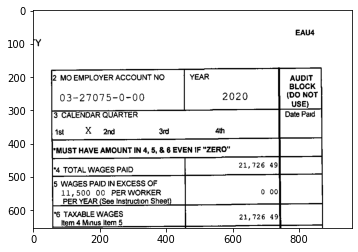

In [14]:
import cv2
import numpy as np
import easyocr
from PIL import Image
import os
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import re
import matplotlib.pyplot as plt


reader = easyocr.Reader(['en'],gpu = False)

image = cv2.imread('/home/vimalkumar.s/Documents/file samples/500 Samples/500/0327075000.tif')
res = image.copy()
width = res.shape[1]
height = res.shape[0]
wi = width * 0.95
he = height * 0.3
w = int(wi)
h = int(he)
y = 0
x1 = w * 0.45
x = int(x1)
crop = res[y:y+h, x:x+w]
plt.imshow(crop)
im = crop.copy()
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpen = cv2.filter2D(gray, -1, sharpen_kernel)
thresh = cv2.threshold(sharpen, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
r_easy_ocr=reader.readtext(thresh,detail=0)
print(r_easy_ocr)

In [18]:
image = cv2.imread('/home/vimalkumar.s/Documents/file samples/test1/0327075000/table-000.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpen = cv2.filter2D(gray, -1, sharpen_kernel)
thresh = cv2.threshold(sharpen, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
r_easy_ocr=reader.readtext(thresh,detail=0)
print(r_easy_ocr)

['16', '18;', '19', "'20", 'Probatlo', 'Probatl', 'Midalo', 'Mult:', 'Proba-', 'onary:', "'SSN", 'Firat:', 'Laet', 'Totol', 'Btrt', 'end', 'Nbmo', "Inital'", "Nama'", 'Wogee', 'atato', 'tiontry', 'Dato', 'Doto:', '538', '31', '5215,', 'Sara', '€', 'lHorn', '0, 432,50', '575', '92', '9002', 'Choon', 'S', 'KKim', '3, 952 ,', '575.', "'19", "'6868 |xoung", 'G', 'KKim', '4,631 00', '494.', '219', '5716 |Marjolyn:', "'8", 'Redd:', '4,710.99', '21 PAGE', 'OF:', '1', 'PaGES;', 'TOTAL ThiS PAGE', '21,726', '49', 'nary']


In [9]:
def find_tables(image):
    BLUR_KERNEL_SIZE = (17, 17)
    STD_DEV_X_DIRECTION = 0
    STD_DEV_Y_DIRECTION = 0
    blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2
    
    img_bin = cv2.adaptiveThreshold(
        ~blurred,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )
    vertical = horizontal = img_bin.copy()
    SCALE = 5
    image_width, image_height = horizontal.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
    horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
    vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    
    horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
    vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))
    
    mask = horizontally_dilated + vertically_dilated
    contours, heirarchy = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE,
    )

    MIN_TABLE_AREA = 1e5
    contours = [c for c in contours if cv2.contourArea(c) > MIN_TABLE_AREA]
    perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
    epsilons = [0.1 * p for p in perimeter_lengths]
    approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]
    bounding_rects = [cv2.boundingRect(a) for a in approx_polys]

    # The link where a lot of this code was borrowed from recommends an
    # additional step to check the number of "joints" inside this bounding rectangle.
    # A table should have a lot of intersections. We might have a rectangular image
    # here though which would only have 4 intersections, 1 at each corner.
    # Leaving that step as a future TODO if it is ever necessary.
    images = [image[y:y+h, x:x+w] for x, y, w, h in bounding_rects]
    return images

def main(files):
    file_path = '/home/vimalkumar.s/Documents/backup/samples/1'
    files = os.listdir(file_path)
    results = []
    for f in files:
        directory, filename = os.path.split(f)
        #image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        image = cv2.imread(os.path.join(file_path,f),0)
        tables = find_tables(image)
        files = []
        filename_sans_extension = os.path.splitext(filename)[0]
        if tables:
            os.makedirs(os.path.join(directory, filename_sans_extension), exist_ok=True)
        for i, table in enumerate(tables):
            table_filename = "table-{:03d}.png".format(i)
            table_filepath = os.path.join(
                directory, filename_sans_extension, table_filename
            )
            files.append(table_filepath)
            cv2.imwrite(table_filepath, table)
        if tables:
            results.append((f, files))
    # Results is [[<input image>, [<images of detected tables>]]]
    return results



In [10]:
file_path = '/home/vimalkumar.s/Documents/backup/samples/1'
files = os.listdir(file_path)
main(files)

[]

In [4]:
import cv2
import os

def extract_cell_images_from_table(image):
    BLUR_KERNEL_SIZE = (17, 17)
    STD_DEV_X_DIRECTION = 0
    STD_DEV_Y_DIRECTION = 0
    blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2
    
    img_bin = cv2.adaptiveThreshold(
        ~blurred,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )
    vertical = horizontal = img_bin.copy()
    SCALE = 5
    image_width, image_height = horizontal.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
    horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
    vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    
    horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
    vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))
    
    mask = horizontally_dilated + vertically_dilated
    contours, heirarchy = cv2.findContours(
        mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE,
    )
    
    perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
    epsilons = [0.05 * p for p in perimeter_lengths]
    approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]
    
    # Filter out contours that aren't rectangular. Those that aren't rectangular
    # are probably noise.
    approx_rects = [p for p in approx_polys if len(p) == 4]
    bounding_rects = [cv2.boundingRect(a) for a in approx_polys]
    
    # Filter out rectangles that are too narrow or too short.
    MIN_RECT_WIDTH = 40
    MIN_RECT_HEIGHT = 10
    bounding_rects = [
        r for r in bounding_rects if MIN_RECT_WIDTH < r[2] and MIN_RECT_HEIGHT < r[3]
    ]
    
    # The largest bounding rectangle is assumed to be the entire table.
    # Remove it from the list. We don't want to accidentally try to OCR
    # the entire table.
    largest_rect = max(bounding_rects, key=lambda r: r[2] * r[3])
    bounding_rects = [b for b in bounding_rects if b is not largest_rect]
    
    cells = [c for c in bounding_rects]
    def cell_in_same_row(c1, c2):
        c1_center = c1[1] + c1[3] - c1[3] / 2
        c2_bottom = c2[1] + c2[3]
        c2_top = c2[1]
        return c2_top < c1_center < c2_bottom
    
    orig_cells = [c for c in cells]
    rows = []
    while cells:
        first = cells[0]
        rest = cells[1:]
        cells_in_same_row = sorted(
            [
                c for c in rest
                if cell_in_same_row(c, first)
            ],
            key=lambda c: c[0]
        )
    
        row_cells = sorted([first] + cells_in_same_row, key=lambda c: c[0])
        rows.append(row_cells)
        cells = [
            c for c in rest
            if not cell_in_same_row(c, first)
        ]
    
    # Sort rows by average height of their center.
    def avg_height_of_center(row):
        centers = [y + h - h / 2 for x, y, w, h in row]
        return sum(centers) / len(centers)
    
    rows.sort(key=avg_height_of_center)
    cell_images_rows = []
    for row in rows:
        cell_images_row = []
        for x, y, w, h in row:
            cell_images_row.append(image[y:y+h, x:x+w])
        cell_images_rows.append(cell_images_row)
    return cell_images_rows

def main(f):
    results = []
    directory, filename = os.path.split(f)
    table = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    rows = extract_cell_images_from_table(table)
    cell_img_dir = os.path.join(directory, "cells")
    os.makedirs(cell_img_dir, exist_ok=True)
    paths = []
    for i, row in enumerate(rows):
        for j, cell in enumerate(row):
            cell_filename = "{:03d}-{:03d}.png".format(i, j)
            path = os.path.join(cell_img_dir, cell_filename)
            cv2.imwrite(path, cell)
            paths.append(path)
    return paths

In [5]:
f = '/home/vimalkumar.s/Documents/backup/samples/1'
main(f)

error: OpenCV(4.5.2) /tmp/pip-req-build-13uokl4r/opencv/modules/imgproc/src/smooth.dispatch.cpp:617: error: (-215:Assertion failed) !_src.empty() in function 'GaussianBlur'


In [6]:
pip install imutils

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25861 sha256=35ba302c8126b0bc053ac23c4031cac5d9af16f61e9ee5d58098b9507a97897b
  Stored in directory: /home/vimalkumar.s/.cache/pip/wheels/59/1b/52/0dea905f8278d5514dc4d0be5e251967f8681670cadd3dca89
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.
